In [373]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm import tqdm

import medmnist
from medmnist import INFO, Evaluator

# Data Preparation

In [374]:
print(medmnist.__version__)
# note there is also mednist+!!

3.0.2


In [375]:
from medmnist import BreastMNIST

train_dataset = BreastMNIST(split='train', download=True)
test_dataset  = BreastMNIST(split='test', download=True)

Using downloaded and verified file: /Users/ramonwinkler/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/ramonwinkler/.medmnist/breastmnist.npz


In [376]:
train_dataset

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /Users/ramonwinkler/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0

In [377]:
print(type(train_dataset))

<class 'medmnist.dataset.BreastMNIST'>


In [378]:
train_dataset.info

{'python_class': 'BreastMNIST',
 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/breastmnist.npz?download=1',
 'MD5': '750601b1f35ba3300ea97c75c52ff8f6',
 'url_64': 'https://zenodo.org/records/10519652/files/breastmnist_64.npz?download=1',
 'MD5_64': '742edef2a1fd1524b2efff4bd7ba9364',
 'url_128': 'https://zenodo.org/records/10519652/files/breastmnist_128.npz?download=1',
 'MD5_128': '363e4b3f8d712e9b5de15470a2aaadf1',
 'url_224': 'https://zenodo.org/records/10519652/files/breastmnist_224.npz?download=1',
 'MD5_224

Note: normal + benign are combined into one class: benign!

In [379]:
print(len(train_dataset))

546


## Convert medmnist datset object into pandas dataframe

In [380]:
# save images and labels in a list
images = []
labels = []

for img, label in train_dataset:
    images.append(np.array(img))
    labels.append(int(label))

In [381]:
# create a df of the extracted data
train_df = pd.DataFrame({
    "image": images,
    "label": labels
})

In [382]:
train_df.head()

,image,label
0,"[[139, 139, 138, 139, 142, 149, 156, 159, 164,...",1
1,"[[82, 85, 83, 78, 76, 76, 79, 79, 76, 80, 86, ...",1
2,"[[157, 155, 151, 145, 149, 146, 141, 134, 141,...",1
3,"[[167, 163, 162, 151, 145, 133, 139, 149, 150,...",1
4,"[[1, 6, 41, 79, 159, 180, 175, 175, 175, 181, ...",0


In [383]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   546 non-null    object
 1   label   546 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [384]:
train_df["label"].value_counts()

label
1    399
0    147
Name: count, dtype: int64

imbalance!

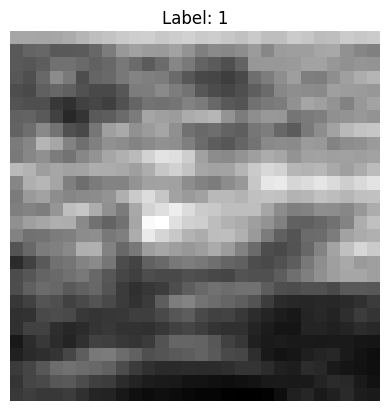

In [385]:
# define a sample
sample = train_df.iloc[0]

img_np = sample["image"] 
label  = sample["label"]

plt.imshow(img_np, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [386]:
print("shape:",img_np.shape)

shape: (28, 28)


In [387]:
# save images and labels in a list
images = []
labels = []

for img, label in test_dataset:
    images.append(np.array(img))
    labels.append(int(label))

In [388]:
# create a df of the extracted data
test_df = pd.DataFrame({
    "image": images,
    "label": labels
})

In [389]:
# extract features (pixels) and labels 
X_test = np.stack(test_df['image'].values)
y_test = np.array(test_df['label'].values)

In [390]:
# Assuming X_test is a numpy array of shape (num_samples, 28, 28)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

## Define a simple classical CNN

In [391]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        """
        Define the layers of the convolutional neural network.

        Parameters:
            in_channels: int
                The number of channels in the input image. For MNIST, this is 1 (grayscale images).
            num_classes: int
                The number of classes we want to predict, in our case 10 (digits 0 to 9).
        """
        super(CNN, self).__init__()

        # First convolutional layer: 1 input channel, 8 output channels, 3x3 kernel, stride 1, padding 1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        # Max pooling layer: 2x2 window, stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer: 8 input channels, 16 output channels, 3x3 kernel, stride 1, padding 1
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Fully connected layer: 16*7*7 input features (after two 2x2 poolings), 10 output features (num_classes)
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        """
        Define the forward pass of the neural network.

        Parameters:
            x: torch.Tensor
                The input tensor.

        Returns:
            torch.Tensor
                The output tensor after passing through the network.
        """
        x = F.relu(self.conv1(x))  # Apply first convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = F.relu(self.conv2(x))  # Apply second convolution and ReLU activation
        x = self.pool(x)           # Apply max pooling
        x = x.reshape(x.shape[0], -1)  # Flatten the tensor
        x = self.fc1(x)            # Apply fully connected layer
        return x

In [392]:
# device definition: gpu/ cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [393]:
# define hyperparameters
n_channels = n_channels = 1 # images are grayscale: each pixel has 1 channel!
nput_size = 784  # 28x28 pixels 
num_classes = 2 # define the number of classes (benign, malignant)
learning_rate = 0.001 # artificial, think about adjusting!
batch_size = 64
num_epochs = 500

In [394]:
import torch
import torch.nn as nn

class CNN_Stronger(nn.Module):
    """
    Slightly stronger CNN for BreastMNIST:
    - 3 convolution layers instead of 2
    - More filters
    - Dropout before final FC
    """
    def __init__(self, in_channels=1, num_classes=2):
        super(CNN_Stronger, self).__init__()

        # First conv block: 1 -> 16
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # halves spatial size

        # Second conv block: 16 -> 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        # Third conv block: 32 -> 64
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(p=0.25)

        # After 3 pools: 28 -> 14 -> 7 -> 3 (approx)
        # Adjust linear layer accordingly
        self.fc1 = nn.Linear(64 * 3 * 3, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)

        x = torch.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x


In [395]:
# create an instance of the cnn class
model = CNN(in_channels=n_channels)

In [396]:
# define loss strategy and optimizer
criterion = nn.CrossEntropyLoss()
    
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # adam optimizes model.parameters!

## Transform training data to torch tensors for CNN input

In [397]:
# extract features (pixels) and labels 
X_train = np.stack(train_df['image'].values)
y_train = np.array(train_df['label'].values)

print(X_train.shape)
print(y_train.shape)

(546, 28, 28)
(546,)


In [398]:
# convert X,y into torch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
y_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

print(X_tensor.shape)
print(y_tensor.shape)

torch.Size([546, 1, 28, 28])
torch.Size([546])


In [399]:
num_samples = X_tensor.shape[0]

## Training

In [400]:
# define the tracking lists
train_losses = []
train_accuracies = []
train_roc_aucs = []

In [401]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
import torch

num_epochs = 100

for epoch in range(num_epochs):
    model.train()  # training mode

    optimizer.zero_grad()                         # reset gradients
    outputs = model(X_tensor)                     # forward pass
    loss = criterion(outputs, y_tensor)           # compute loss
    loss.backward()                               # compute gradients
    optimizer.step()                              # update weights

    # ---- Training metrics ----
    with torch.no_grad():
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        true = y_tensor.cpu().numpy()

        train_acc = accuracy_score(true, preds)
        train_auc = roc_auc_score(true, probs)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss.item():.4f} | "
          f"Train Acc: {train_acc:.4f} | Train AUC: {train_auc:.4f}")

# --------------------------
# Evaluate on the test set
# --------------------------
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)

    test_probs = torch.softmax(test_outputs, dim=1)[:, 1].cpu().numpy()
    test_preds = torch.argmax(test_outputs, dim=1).cpu().numpy()
    test_true = y_test_tensor.cpu().numpy()

    test_acc = accuracy_score(test_true, test_preds)
    test_auc = roc_auc_score(test_true, test_probs)

print("\nTEST PERFORMANCE")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC:      {test_auc:.4f}")


Epoch 1/200 | Loss: 31.6974 | Train Acc: 0.0018 | Train AUC: 0.4735
Epoch 2/200 | Loss: 15.8519 | Train Acc: 0.2436 | Train AUC: 0.4803
Epoch 3/200 | Loss: 3.3501 | Train Acc: 0.3553 | Train AUC: 0.5370
Epoch 4/200 | Loss: 3.6940 | Train Acc: 0.7308 | Train AUC: 0.5731
Epoch 5/200 | Loss: 6.3867 | Train Acc: 0.7308 | Train AUC: 0.5092
Epoch 6/200 | Loss: 7.6177 | Train Acc: 0.7308 | Train AUC: 0.5152
Epoch 7/200 | Loss: 7.8338 | Train Acc: 0.7308 | Train AUC: 0.5131
Epoch 8/200 | Loss: 7.3675 | Train Acc: 0.7308 | Train AUC: 0.5117
Epoch 9/200 | Loss: 6.4576 | Train Acc: 0.7308 | Train AUC: 0.5175
Epoch 10/200 | Loss: 5.2728 | Train Acc: 0.7308 | Train AUC: 0.5359
Epoch 11/200 | Loss: 3.9326 | Train Acc: 0.7308 | Train AUC: 0.6128
Epoch 12/200 | Loss: 2.5319 | Train Acc: 0.7344 | Train AUC: 0.6449
Epoch 13/200 | Loss: 1.2599 | Train Acc: 0.7326 | Train AUC: 0.6569
Epoch 14/200 | Loss: 1.0812 | Train Acc: 0.6099 | Train AUC: 0.6598
Epoch 15/200 | Loss: 2.3170 | Train Acc: 0.3718 | Train

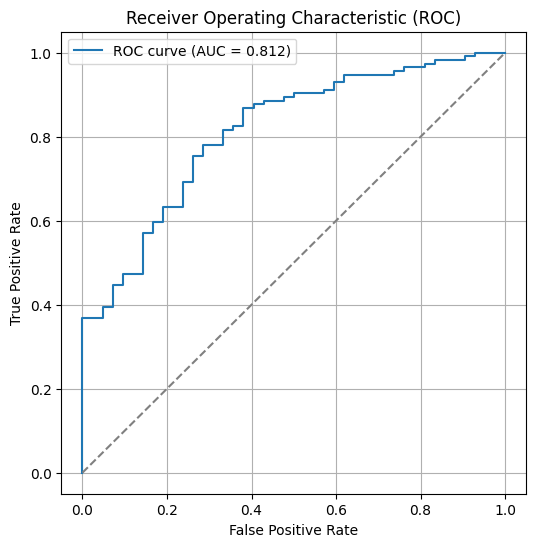

In [403]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve points
fpr, tpr, thresholds = roc_curve(test_true, test_probs)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")

# Diagonal line for random guessing
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.grid(True)
plt.show()


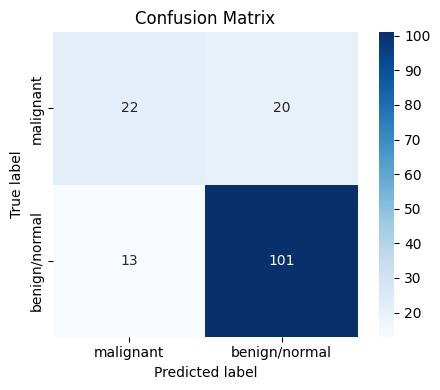

In [404]:
# Compute confusion matrix
cm = confusion_matrix(test_true, test_preds)

# Your desired class order
class_names = ["malignant", "benign/normal"]

plt.figure(figsize=(5, 4))

sns.heatmap(
    cm,
    annot=True,          # show numbers
    fmt="d",             # integer format
    cmap="Blues",
    cbar=True,
    xticklabels=class_names,
    yticklabels=class_names,
    square=True
)

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()